# 深度学习模型训练和关键参数调优详解

针对特定场景任务从**模型选择、模型训练、超参优化、效果展示**这四个方面进行模型开发。

参考资料：
- [最实用的项目开发全流程!从自建数据集到模型部署,其实没有这么难!](https://aistudio.baidu.com/aistudio/projectdetail/671871)
- [神经网络前向传播原理详解](https://aistudio.baidu.com/aistudio/projectdetail/742777)
- [写给小白的入门笔记，神经网络梯度下降原理详解](https://aistudio.baidu.com/aistudio/projectdetail/757995)
- [使用飞桨可解释性算法库InterpretDL解析人脸识别模型](https://aistudio.baidu.com/aistudio/projectdetail/1658188)

# 一、模型选择

从任务类型出发，选择最合适的模型。

## 1.回归任务

从使用Numpy推导，到使用深度学习框架，一步步走进最简单的回归任务：[当人工智能邂逅蓝桥杯算法题，会擦出怎样的火花？](https://aistudio.baidu.com/aistudio/projectdetail/1693536)

### 人脸关键点检测

完整代码详见[基于空间注意力SAM的GoogLeNet实现人脸关键点检测并自动添加表情贴纸](https://aistudio.baidu.com/aistudio/projectdetail/1533049)

![](https://ai-studio-static-online.cdn.bcebos.com/0ccfc3abc6574d18aba1649687a464730f426b839b9c4a409eb2f75629fce9dc)


68点的人脸关键点检测：

<img style="display: block; margin: 0 auto;zoom:30%;" src="https://ai-studio-static-online.cdn.bcebos.com/a9161a11b91b468497e9fbbf565a0a638ace47b2a6c54748a7bd2e497ea0727f" alt=""/>

- 1-17：人脸的下轮廓
- 18-27：眉毛
- 28-36： 鼻子
- 37-48：眼睛
- 49-68：嘴巴

人脸关键点检测任务中，输出为 **人脸关键点的数量x2**，即每个人脸关键点的横坐标与纵坐标。在模型组网时，主要使用2个模块，分别是Inception模块和空间注意力模块。增加空间注意力模块是为了提高模型效果。

- **Inception模块**

GoogLeNet是由Inception模块进行组成的，GoogLeNet采用了模块化的结构，因此修改网络结构时非常简单方便。

![](https://ai-studio-static-online.cdn.bcebos.com/ab2001ee42114943af663e5313e18751d43f1262e8b14ae68118a1d54e0ee66a)


In [ ]:
import paddle
import paddle.nn as nn

# GoogLeNet加BN层加速模型收敛
class Inception(nn.Layer): # 定义Inception块（Inception v1）
    def __init__(self,c1, c2, c3, c4):
        super(Inception, self).__init__()

        self.relu = nn.ReLU()
        self.p1_1 = nn.Conv2D(c1[0], c1[1], 1)
        self.p2_1 = nn.Conv2D(c1[0], c2[0], 1)
        self.p2_2 = nn.Conv2D(c2[0], c2[1], 3, padding=1)
        self.p3_1 = nn.Conv2D(c1[0], c3[0], 1)
        self.p3_2 = nn.Conv2D(c3[0], c3[1], 5, padding=2)
        self.p4_1 = nn.MaxPool2D(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2D(c1[0], c4, 1)

    def forward(self, x):
        p1 = self.relu(self.p1_1(x))
        p2 = self.relu(self.p2_2(self.p2_1(x)))
        p3 = self.relu(self.p3_2(self.p3_1(x)))
        p4 = self.relu(self.p4_2(self.p4_1(x)))

        return paddle.concat([p1, p2, p3, p4], axis=1)

- **空间注意力模块**

空间注意力聚焦在“哪里”是最具信息量的部分。计算空间注意力的方法是沿着通道轴应用平均池化和最大池操作，然后将它们连接起来生成一个有效的特征描述符。

![](https://ai-studio-static-online.cdn.bcebos.com/056c7bd40bc240478419aa3926b2652145f3a30d6d7d43c7ac356d6949b680f3)

In [ ]:
import paddle
import paddle.nn as nn

# 空间注意力机制
class SAM_Module(nn.Layer):  
    def __init__(self):  
        super(SAM_Module, self).__init__()  
        self.conv_after_concat = nn.Conv2D(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3)  
        self.sigmoid_spatial = nn.Sigmoid()  

    def forward(self, x):  
        # Spatial Attention Module  
        module_input = x  
        avg = paddle.mean(x, axis=1, keepdim=True)  
        mx = paddle.argmax(x, axis=1, keepdim=True)
        mx = paddle.cast(mx, 'float32')
        x = paddle.concat([avg, mx], axis=1)
        x = self.conv_after_concat(x)  
        x = self.sigmoid_spatial(x)  
        x = module_input * x  

        return x  

## 2.分类任务

CIFAR-10数据集也是分类任务中一个非常经典的数据集，在科研中，常常使用CIFAR数据集评估算法的性能。

### 图像分类

基于CIFAR-10数据集实现图像10分类。项目完整代码详见：[从论文到代码深入解析带有门控单元的gMLP算法](https://aistudio.baidu.com/aistudio/projectdetail/2134364)

gMLP中，最核心的部分就是**空间选通单元(Spatial Gating Unit,SGU)**，它的结构如下图所示：

<img style="display: block; margin: 0 auto;" src="https://ai-studio-static-online.cdn.bcebos.com/1cf002e743094b2aab6a4f116d25592f380f0391e1214441bdb6228bcf7e95b1" width = "80%" height = "80%" />


In [ ]:
import paddle
import paddle.nn as nn

class SpatialGatingUnit(nn.Layer):
    def __init__(self, dim, dim_seq, act = None):
        super(SpatialGatingUnit, self).__init__()
        dim_out = dim // 2

        self.norm = nn.LayerNorm(normalized_shape = dim_out)
        self.proj = nn.Conv1D(in_channels = dim_seq, out_channels = dim_seq, kernel_size = 1)
        self.act = act


    def forward(self, x):
        res, gate = paddle.chunk(x, 2, axis=-1)
        gate = self.norm(gate)
        gate = self.proj(gate.transpose((0, 2, 1)))
        if self.act:
            gate = self.act(gate)
        y = gate * res.transpose((0, 2, 1))
        y = y.transpose((0, 2, 1))

        return y

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


查看网络结构：

In [ ]:
sgu = SpatialGatingUnit(32, 16)
paddle.summary(sgu, (3, 32, 32))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
  LayerNorm-1      [[3, 32, 16]]         [3, 32, 16]            32       
   Conv1D-1        [[3, 16, 32]]         [3, 16, 32]            272      
Total params: 304
Trainable params: 304
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.04
---------------------------------------------------------------------------



{'total_params': 304, 'trainable_params': 304}

gMLP是由一个个gMLP block构成的，上面我们已经把gMLP block中最重要的空间选通单元(Spatial Gating Unit,SGU)实现了，接下来我们只需要拿来用即可，代码如下：

In [ ]:
import paddle
import paddle.nn as nn

class gMLPBlock(nn.Layer):
    def __init__(self, dim, dim_ff, seq_len, act = None):
        super(gMLPBlock, self).__init__()
        self.proj_in = nn.Sequential(
            nn.Linear(dim, dim_ff),
            nn.GELU()
        )

        self.sgu = SpatialGatingUnit(dim_ff, seq_len, act)
        self.proj_out = nn.Linear(dim_ff // 2, dim)

    def forward(self, x):
        x = self.proj_in(x)
        x = self.sgu(x)
        x = self.proj_out(x)
        return x

查看网络结构：

In [ ]:
gMLP_block = gMLPBlock(32, 32, 16)
paddle.summary(gMLP_block, (3, 32, 32))

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Linear-4          [[3, 32, 32]]         [3, 32, 32]           1,056     
      GELU-1           [[3, 32, 32]]         [3, 32, 32]             0       
    LayerNorm-2        [[3, 32, 16]]         [3, 32, 16]            32       
     Conv1D-2          [[3, 16, 32]]         [3, 16, 32]            272      
SpatialGatingUnit-2    [[3, 32, 32]]         [3, 32, 16]             0       
     Linear-5          [[3, 32, 16]]         [3, 32, 32]            544      
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
-------------------------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.01
Estimated Total Size (MB): 0.12
-------------------------------------------------------------------------------



{'total_params': 1904, 'trainable_params': 1904}

将上面的gMLP block堆叠起来，就构成了gMLPs，代码如下：

In [ ]:
import paddle
import paddle.nn as nn

def pair(val):
    return (val, val) if not isinstance(val, tuple) else val

class PatchEmbed(nn.Layer):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=32, patch_size=16, in_chans=3, embed_dim=768):
        super(PatchEmbed, self).__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.project = nn.Conv2D(in_chans, embed_dim, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.project(x)
        x = x.flatten(2)
        x = paddle.transpose(x, perm=[0, 2, 1])
        return x

class Residual(nn.Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

class PreNorm(nn.Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, **kwargs):
        x = self.norm(x)
        return self.fn(x, **kwargs)

class gMLPVision(nn.Layer):
    def __init__(
        self,
        image_size,
        patch_size,
        num_classes,
        dim,
        depth,
        ff_mult = 4,
        channels = 3,
    ):
        super(gMLPVision, self).__init__()
        self.image_height, self.image_width = pair(image_size)
        self.patch_height, self.patch_width = pair(patch_size)
        assert (self.image_height % self.patch_height) == 0 and (self.image_width % self.patch_width) == 0, 'image height and width must be divisible by patch size'
        num_patches = (self.image_height // self.patch_height) * (self.image_width // self.patch_width)

        dim_ff = dim * ff_mult

        self.to_patch_embed = nn.Sequential(
            # 'b c (h p1) (w p2) -> b (h w) (c p1 p2)', p1 = patch_height, p2 = patch_width
            PatchEmbed(img_size=image_size, patch_size=patch_size, in_chans=3, embed_dim=channels * self.patch_height * self.patch_width),
            nn.Linear(channels * self.patch_height * self.patch_width, dim)
        )

        self.layers = nn.LayerList([Residual(PreNorm(dim, gMLPBlock(dim = dim, dim_ff = dim_ff, seq_len = num_patches))) for i in range(depth)])

        self.norn = nn.LayerNorm(dim)
    
        self.to_logits = nn.Sequential(
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embed(x)
        layers = self.layers
        x = nn.Sequential(*layers)(x)
        x = self.norn(x)
        x = x.mean(axis=1)
        return self.to_logits(x)

查看gMLPs模型（共30层，维度为128）结构：

In [ ]:
gmlp_vision = gMLPVision(
    image_size = 32,
    patch_size = 2,
    num_classes = 10,
    dim = 128,
    depth = 30
)
paddle.summary(gmlp_vision, (32, 3, 32, 32))

```
===================================================================
Total params: 4,968,486
Trainable params: 4,968,486
Non-trainable params: 0
-------------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 4577.50
Params size (MB): 18.95
Estimated Total Size (MB): 4596.83
-------------------------------------------------------------------

{'total_params': 4968486, 'trainable_params': 4968486}
```

## 3.场景任务

这里说的场景任务是针对某一个特定的场景开发的深度学习任务，相比于回归和分类任务来说，场景任务的难度更高。这里说的场景任务包括但不限于目标检测、图像分割、文本生成、语音合成、强化学习等。

- [PaddleX模型库](https://paddlex.readthedocs.io/zh_CN/develop/appendix/model_zoo.html)
- [PaddleGAN模型库](https://gitee.com/paddlepaddle/PaddleGAN/blob/master/docs/zh_CN/apis/apps.md)
- [PaddleOCR模型库](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.1/doc/doc_ch/models_list.md)
- [PaddleHub模型库](https://www.paddlepaddle.org.cn/hublist)

### 目标检测

基于PaddleX的YOLOv3模型快速实现[昆虫检测](https://aistudio.baidu.com/aistudio/projectdetail/442375)。

安装PaddleX：

In [14]:
!pip install paddlex -i https://mirror.baidu.com/pypi/simple

PaddleX里的目标检测模型，这里选择骨干网络为DarkNet53的YOLO-V3模型：

In [ ]:
import paddlex as pdx

yolo_v3 = pdx.det.YOLOv3(
    num_classes=2, 
    backbone='DarkNet53'
)

yolo_v3.get_model_info()

{'version': '1.3.11',
 'Model': 'YOLOv3',
 '_Attributes': {'model_type': 'detector',
  'num_classes': 2,
  'labels': None,
  'fixed_input_shape': None},
 '_init_params': {'num_classes': 2,
  'backbone': 'DarkNet53',
  'anchors': None,
  'anchor_masks': None,
  'ignore_threshold': 0.7,
  'nms_score_threshold': 0.01,
  'nms_topk': 1000,
  'nms_keep_topk': 100,
  'nms_iou_threshold': 0.45,
  'label_smooth': False,
  'train_random_shapes': [320, 352, 384, 416, 448, 480, 512, 544, 576, 608],
  'input_channel': 3},
 'completed_epochs': 0}

### 人像分割

基于PaddleX核心分割模型 Deeplabv3+Xcetion65 & HRNet_w18_small_v1 实现[人像分割](https://paddlex.readthedocs.io/zh_CN/develop/examples/human_segmentation.html)，PaddleX提供了人像分割的预训练模型，可直接使用，当然也可以根据自己的数据做微调。

下载PaddleX源码:

In [8]:
!git clone https://gitee.com/PaddlePaddle/PaddleX

Cloning into 'PaddleX'...
remote: Enumerating objects: 1890, done.
remote: Counting objects: 100% (1890/1890), done.
remote: Compressing objects: 100% (682/682), done.
remote: Total 20433 (delta 1201), reused 1849 (delta 1180), pack-reused 18543
Receiving objects: 100% (20433/20433), 77.88 MiB | 9.81 MiB/s, done.
Resolving deltas: 100% (13546/13546), done.
Checking connectivity... done.


下载预训练模型的代码位于PaddleX/examples/human_segmentation，进入该目录，并下载预训练模型：

In [15]:
%cd PaddleX/examples/human_segmentation

In [16]:
!python pretrain_weights/download_pretrain_weights.py

对人像视频进行分割处理：

In [17]:
!python video_infer.py --model_dir pretrain_weights/humanseg_mobile_inference --video_path data/test.mp4

预测结果会保存到output文件夹下的result.avi文件里。

![](https://ai-studio-static-online.cdn.bcebos.com/6e6d2b5ab2c94b64afb3ee1728bdf7c1f29f454d76d1420286e9d98260d05ae4)


### 文字识别

基于chinese_ocr_db_crnn_mobile实现[文字识别](https://www.paddlepaddle.org.cn/hubdetail?name=chinese_ocr_db_crnn_mobile&en_category=TextRecognition)，识别图片当中的汉字，该Module是一个超轻量级中文OCR模型，支持直接预测。

安装文字识别模型以及必要的资源库：

In [18]:
!hub install chinese_ocr_db_crnn_mobile==1.1.2

In [19]:
!pip install shapely
!pip install pyclipper

调用预训练模型进行预测：

In [23]:
import paddlehub as hub
import cv2

ocr = hub.Module(name="chinese_ocr_db_crnn_mobile")
result = ocr.recognize_text(images=[cv2.imread('/home/aistudio/work/OCR/ocrdemo.png')], 
                            output_dir='/home/aistudio/work/OCR/ocr_result', 
                            visualization=True)


![](https://ai-studio-static-online.cdn.bcebos.com/46507916316a43d9a0e129c76b1668a03ef8cf9e817a469e854aaf82354cd1ea)

# 二、模型训练

仅基于原生Python和Numpy看模型训练**基本原理**：[神经网络梯度下降原理详解](https://aistudio.baidu.com/aistudio/projectdetail/757995)

### 1.基于高层API训练模型

通过Model.prepare接口来对训练进行提前的配置准备工作，包括设置模型优化器，Loss计算方法，精度计算方法等。

```
import paddle

# 使用paddle.Model完成模型的封装
model = paddle.Model(Net)

# 为模型训练做准备，设置优化器，损失函数和精度计算方式
model.prepare(optimizer=paddle.optimizer.Adam(parameters=model.parameters()),
              loss=paddle.nn.CrossEntropyLoss(),
              metrics=paddle.metric.Accuracy())

# 调用fit()接口来启动训练过程
model.fit(train_dataset,
          epochs=1,
          batch_size=64,
          verbose=1)
```

#### 加载数据集

论文里将gMLP应用到ImageNet上的图像分类任务中，而不使用额外的数据，从而在视觉领域检查gMLP。但是ImageNet数据集较大，为了节省时间，这里使用Cifar10进行验证。

In [ ]:
import paddle.vision as vision
import paddle
import paddle.vision.transforms as transforms
from paddle.vision.transforms import Normalize

normalize = transforms.Normalize(
    [0.4914*255, 0.4822*255, 0.4465*255], [0.2023*255, 0.1994*255, 0.2010*255])

trainTransforms = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(), 
                transforms.Transpose(),
                normalize
            ])

testTransforms = transforms.Compose([
                transforms.Transpose(),
                normalize
            ])

trainset = vision.datasets.Cifar10(mode='train', transform=trainTransforms)
trainloader = paddle.io.DataLoader(trainset, batch_size=128, num_workers=0, shuffle=True)
testset = vision.datasets.Cifar10(mode='test', transform=testTransforms)
testloader = paddle.io.DataLoader(testset, batch_size=128, num_workers=0, shuffle=True)

#### 模型封装

以使用paddle.Model完成模型的封装，将网络结构组合成一个可快速使用高层API进行训练和预测的对象。代码如下：

In [ ]:
model = paddle.Model(gmlp_vision)

#### 训练参数配置

用paddle.Model完成模型的封装后，在训练前，需要对模型进行配置，通过Model.prepare接口来对训练进行提前的配置准备工作，包括设置模型优化器，Loss计算方法，精度计算方法等。

In [ ]:
# 调用飞桨框架的VisualDL模块，保存信息到目录中。
callback = paddle.callbacks.VisualDL(log_dir='gMLP_log_dir')

def create_optim(parameters):
    step_each_epoch = len(trainloader) // 128
    lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.25,
                                                  T_max=step_each_epoch * 120)

    return paddle.optimizer.Adam(learning_rate=lr,
                                 parameters=parameters,
                                 weight_decay=paddle.regularizer.L2Decay(3e-4))

model.prepare(create_optim(model.parameters()),  # 优化器
              paddle.nn.CrossEntropyLoss(),        # 损失函数
              paddle.metric.Accuracy(topk=(1, 5))) # 评估指标

#### 模型训练

做好模型训练的前期准备工作后，调用fit()接口来启动训练过程，需要指定至少3个关键参数：训练数据集，训练轮次和单次训练数据批次大小。

In [ ]:
model.fit(trainloader,
          testloader,
          epochs=120,
          eval_freq=2,
          shuffle=True, 
          save_dir='gMLP_case1_chk_points/',
          save_freq=20,
          batch_size=128,
          callbacks=callback,
          verbose=1)

```
Epoch 120/120
step 391/391 [==============================] - loss: 1.3216 - acc_top1: 0.6175 - acc_top5: 0.9607 - 311ms/step

Eval begin...
step 79/79 [==============================] - loss: 0.6662 - acc_top1: 0.6014 - acc_top5: 0.9587 - 92ms/step        
Eval samples: 10000
```

### 2.使用PaddleX训练模型

YOLOv3模型的训练接口示例，函数内置了piecewise学习率衰减策略和momentum优化器。

```
model.train(
    num_epochs=270,
    train_dataset=train_dataset,
    train_batch_size=8,
    eval_dataset=eval_dataset,
    learning_rate=0.000125,
    lr_decay_epochs=[210, 240],
    save_dir='output/yolov3_darknet53',
    use_vdl=True)
```

#### 配置数据集

In [ ]:
from paddlex.det import transforms
import paddlex as pdx

# 下载和解压昆虫检测数据集
insect_dataset = 'https://bj.bcebos.com/paddlex/datasets/insect_det.tar.gz'
pdx.utils.download_and_decompress(insect_dataset, path='./')

# 定义训练和验证时的transforms
# API说明 https://paddlex.readthedocs.io/zh_CN/develop/apis/transforms/det_transforms.html
train_transforms = transforms.Compose([
    transforms.MixupImage(mixup_epoch=250), transforms.RandomDistort(),
    transforms.RandomExpand(), transforms.RandomCrop(), transforms.Resize(
        target_size=608, interp='RANDOM'), transforms.RandomHorizontalFlip(),
    transforms.Normalize()
])

eval_transforms = transforms.Compose([
    transforms.Resize(
        target_size=608, interp='CUBIC'), transforms.Normalize()
])

# 定义训练和验证所用的数据集
# API说明：https://paddlex.readthedocs.io/zh_CN/develop/apis/datasets.html#paddlex-datasets-vocdetection
train_dataset = pdx.datasets.VOCDetection(
    data_dir='insect_det',
    file_list='insect_det/train_list.txt',
    label_list='insect_det/labels.txt',
    transforms=train_transforms,
    shuffle=True)
eval_dataset = pdx.datasets.VOCDetection(
    data_dir='insect_det',
    file_list='insect_det/val_list.txt',
    label_list='insect_det/labels.txt',
    transforms=eval_transforms)


#### 初始化模型

In [ ]:
# 可使用VisualDL查看训练指标，参考https://paddlex.readthedocs.io/zh_CN/develop/train/visualdl.html
num_classes = len(train_dataset.labels)

# API说明: https://paddlex.readthedocs.io/zh_CN/develop/apis/models/detection.html#paddlex-det-yolov3
model = pdx.det.YOLOv3(num_classes=num_classes, backbone='DarkNet53')

#### 模型训练

In [ ]:
# API说明: https://paddlex.readthedocs.io/zh_CN/develop/apis/models/detection.html#id1
# 各参数介绍与调整说明：https://paddlex.readthedocs.io/zh_CN/develop/appendix/parameters.html
model.train(
    num_epochs=270,
    train_dataset=train_dataset,
    train_batch_size=8,
    eval_dataset=eval_dataset,
    learning_rate=0.000125,
    lr_decay_epochs=[210, 240],
    save_dir='output/yolov3_darknet53',
    use_vdl=True)

```
2021-07-15 20:52:54 [INFO]	Decompressing output/yolov3_darknet53/pretrain/DarkNet53_ImageNet1k_pretrained.tar...
2021-07-15 20:52:55 [INFO]	Load pretrain weights from output/yolov3_darknet53/pretrain/DarkNet53_ImageNet1k_pretrained.
2021-07-15 20:52:55 [INFO]	There are 260 varaibles in output/yolov3_darknet53/pretrain/DarkNet53_ImageNet1k_pretrained are loaded.
2021-07-15 20:53:03 [INFO]	[TRAIN] Epoch=1/270, Step=2/21, loss=18702.005859, lr=0.0, time_each_step=3.84s, eta=6:5:32
2021-07-15 20:53:04 [INFO]	[TRAIN] Epoch=1/270, Step=4/21, loss=8156.868164, lr=0.0, time_each_step=2.12s, eta=3:21:43
2021-07-15 20:53:04 [INFO]	[TRAIN] Epoch=1/270, Step=6/21, loss=10086.267578, lr=1e-06, time_each_step=1.53s, eta=2:25:42
```

### 3.模型训练通用配置基本原则

1. 每个输入数据的维度要保持一致，且一定要和模型输入保持一致。
2. 配置学习率衰减策略时，训练的上限轮数一定要计算正确。
3. BatchSize不宜过大，太大容易内存溢出，且一般为2次幂。

# 三、超参优化

## 1.超参优化的基本概念


### 参数

参数是机器学习算法的关键，是从训练数据中学习到的，属于模型的一部分。

![](https://ai-studio-static-online.cdn.bcebos.com/574d04bab0344f8fbcbbdb9bdb1a6c7393b1d6c550474f7f8056cb0048f086c8)

输入一个值（x），乘以权重，结果就是网络的输出值。权重可以随着网络的训练进行更新,从而找到最佳的值,这样网络就能尝试匹配输出值与目标值。

这里的权重其实就是一种参数。


### 超参数

模型的超参数指的是**模型外部**的配置变量，是不能通过训练的进行来估计其取值不同的，且不同的训练任务往往需要不同的超参数。

超参数不同，最终得到的模型也是不同的。

一般来说，超参数有：**学习率**，**迭代次数**，**网络的层数**，**每层神经元的个数**等等。

常见的超参数有以下三类：
1. **网络结构**，包括神经元之间的连接关系、层数、每层的神经元数量、激活函数的类型等 .
2. **优化参数**，包括优化方法、学习率、小批量的样本数量等 .
3. **正则化系数** 

实践中，当你使⽤神经⽹络解决问题时，**寻找好的超参数其实是一件非常困难的事情**，对于刚刚接触的同学来说，都是"佛系调优"，这也是一开始就"入土"的原因，没有依据的盲目瞎调肯定是不行的。



## 2.手动调整超参数的四大方法

我们在使用某一网络时，一般是比较好的论文中出现过的，是证明过的，当然也可以直接套用，然后在这个基础上，调参。

可是如果识别的领域不同，比如同样是LeNet网络，在解决手写数字识别时使用的超参数能得到很好的效果，但是在做眼疾识别时，因为数据集的不同，虽然使用同样的超参数，但是效果可能并不理想。

在<< Neural Network and Deep Learning >>这本书中，作者给出⼀些⽤于设定超参数的启发式想法。⽬的是帮读者发展出⼀套工作流来确保很好地设置超参数。这里我把书上的内容总结一下，再结合自己的思考，与大家共同探讨调整超参数的方法论。

不过呢，**目前不存在⼀种通用的关于正确策略的共同认知**，这也是超参数调节的"玄学"之处。


### 1）使用提前停止来确定训练的迭代次数

这个策略是我的老师最早教我的，个人认为这也是防止过拟合最直接的方式。

做法其实很简单，做一个判断，满足条件时退出循环,终止训练：

```python
for epoch in range(MAX_EPOCH):
	// 训练代码
	print('{}[TRAIN]epoch {}, iter {}, output loss: {}'.format(timestring, epoch, i, loss.numpy()))
	if ():
		break
	model.train()
```


那么这个if条件判断就十分重要了,这里有两种方案:

1. 分类准确率不再提升时
2. loss降到一个想要的范围时



#### 分类准确率不再提升时

我们需要再明确⼀下什么叫做分类准确率不再提升，这样方可实现提前停止。

我们知道，分类准确率在整体趋势下降的时候仍旧会抖动或者震荡。如果我们在准确度刚开始下降的时候就停止，那么肯定会错过更好的选择。⼀种不错的解决方案是如果分类准确率在⼀段时间内不再提升的时候终止。

当然这块用loss也是可以的，loss也是一个评判标准。



#### loss降到一个想要的范围时

这是我经常使用的、更直接的方法。

因为网络有时候会在很长时间内于⼀个特定的分类准确率附近形成平缓的局面，然后才会有提升。如果你想获得相当好的性能，第一种方案（分类准确率不再提升时）的规则可能就会太过激进了 —— 停止得太草率。

而本方案（loss降到一个想要的范围时）能很好地解决这一问题，但随之而来的问题就是不知不觉地又多了一个超参数，实际应用上，这个用于条件判断的loss值的选择也很困难。

### 2）让学习率从高逐渐降低

我们⼀直都将学习速率设置为常量。但是，通常采用可变的学习速率更加有效。

如果学习率设置的过低，在训练的前期，训练速度会非常慢；而学习率设置地过高，在训练的后期，又会产生震荡，降低模型的精度：

![](https://ai-studio-static-online.cdn.bcebos.com/9e259595dbb545cb8e61c4e0bbe68e6c216a86f43b1240fb812eb9be04c3a26e)

所以最好是在前期使用一个较大的学习速率让权重变化得更快。越往后，我们可以降低学习速率，这样可以作出更加精良的调整。

⼀种自然的观点是使用提前终止的想法。就是保持学习速率为⼀个常量直到验证准确率开始变差，然后按照某个量下降学习速率。我们重复此过程若干次，直到学习速率是初始值的 1/1024（或者1/1000）,然后终止训练。

### 3）宽泛策略

在使用神经网络来解决新的问题时，⼀个挑战就是获得任何⼀种非寻常的学习，也就是说，达到比随机的情况更好的结果。

也许下面的方法能给你带来某些不一样的启发:

1. 通过简化网络来加速实验进行更有意义的学习
2. 通过更加频繁的监控验证准确率来获得反馈



#### 通过简化网络来加速实验进行更有意义的学习

假设，我们第⼀次遇到 MNIST 分类问题。刚开始，你很有激情，但是当模型完全失效时，你会就得有些沮丧。

此时就可以将问题简化，将十分类问题转化成二分类问题。丢开训练和验证集中的那些除了 0 和 1的那些图像，即我们只识别0和1。然后试着训练⼀个网络来区分 0 和 1。

这样一来，不仅仅问题比 10 个分类的情况简化了，同样也会减少 80% 的训练数据，这样就多出了 5 倍的加速。同时也可以保证更快的实验，也能给予你关于如何构建好的网络更快的洞察。

#### 通过更加频繁的监控验证准确率来获得反馈

这个方法调的其实是输出:

```python
if i % 200 == 0:
	timestring = time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()))
	print('{}[VALID]epoch {}, iter {}, output loss: {}'.format(timestring, epoch, i, loss.numpy()))
```
对模型本身并没有任何关系，但是，你能得到更多并且更快地得到反馈，从而快速地实验其他的超参数，或者甚至近同步地进行不同参数的组合的评比。

这一点看似不重要，但对于超参数的调整来说,是很重要的一步

因为在实际的应用中，很容易会遇到神经网络学习不到任何知识的情况。你可能要花费若干天在调整参数上，仍然没有进展。所以在前期的时候，就应该从实验中尽可能早的获得快速反馈。直觉上看，这看起来简化问题和架构仅仅会降低你的效率。而实际上，这样能够将进度加快，因为你能够更快地找到传达出有意义的信号的网络。⼀旦你获得这些信号，你可以尝试通过微调超参数获得快速的性能提升。

这和人生中很多情况⼀样 —— 万事开头难。

### 4）小批量数据(mini-batch)大小不必最优

假设我们使用大小为 1 的小批量数据。而一般来说，使用只有⼀个样本的小批量数据会带来关于梯度的错误估计。

而实际上，误差并不会真的产⽣这个问题。原因在于单⼀的梯度估计不需要绝对精确。我们需要的是确保代价函数保持下降足够精确的估计。

这就好像你现在要去北极点，但是只有⼀个不太精确的指南针。如果你不再频繁地检查指南针，指南针会在平均状况下给出正确的⽅向，所以最后你也能抵达北极点。

不过使用更大的小批量数据看起来还是显著地能够进行训练加速的。

所以，选择最好的小批量数据大小是⼀种折中。小批量数据太小会加长训练时间；而小批量数据太大是不能够足够频繁地更新权重的。你所需要的是选择⼀个折中的值，可以最大化学习的速度。

幸运的是，小批量数据大小的选择其实是相对独立的⼀个超参数（网络整体架构外的参数），所以你不需要优化那些参数来寻找好的小批量数据大小。

因此，可以选择的方式就是使用某些可以接受的值（不需要是最优的）作为其他参数的选择，然后进行不同小批量数据大小的尝试，就像上面调整学习率那样,画出验证准确率的值随时间（非回合）变化的图，选择得到最快性能提升的小批量数据大小。


# 四、效果展示

## 1.可视化输入与输出

直接可视化输入与输出是最直接的方法。

```
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(PATH_TO_IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()
```

![](https://ai-studio-static-online.cdn.bcebos.com/ce8f83a24ec1423789311f8f8bf674741db96dc8990b450188ed7d7d17d596c3)


## 2.巧用VisualDL

VisualDL文档：[https://ai.baidu.com/ai-doc/AISTUDIO/Dk3e2vxg9#visualdl%E5%B7%A5%E5%85%B7](https://ai.baidu.com/ai-doc/AISTUDIO/Dk3e2vxg9#visualdl%E5%B7%A5%E5%85%B7)

<p align="center">
  <img src="https://user-images.githubusercontent.com/48054808/119312835-709e9980-bca5-11eb-9fce-2bbd2523dedb.gif" width="70%"/>
</p>

完整示例代码请参考：[VisualDL2.2全新升级--可视化分析助力模型快速开发](https://aistudio.baidu.com/aistudio/projectdetail/1990920)

In [24]:
!pip install --upgrade visualdl

### VisualDL可视化流程

1. 创建日志文件：

*为了快速找到最佳超参，训练9个不同组合的超参实验，创建方式均相同如下：

```
writer = LogWriter("./log/lenet/run1")
```

2. 训练前记录每组实验的超参数名称和数值，且记录想要展示的模型指标名称

```
writer.add_hparams({'learning rate':0.0001, 'batch size':64, 'optimizer':'Adam'}, ['train/loss', 'train/acc'])
```

**注意：这里记录的想要展示的模型指标为'train/loss'和 'train/acc'，后续切记需要用`add_scalar`接口记录对应数值**

3. 训练过程中插入作图语句，记录accuracy和loss的变化趋势，同时将展示于Scalar和HyperParameters两个界面中：
```
writer.add_scalar(tag="train/loss", step=step, value=cost)

writer.add_scalar(tag="train/acc", step=step, value=accuracy)
```
4. 记录每一批次中的第一张图片：
```
img = np.reshape(batch[0][0], [28, 28, 1]) * 255

writer.add_image(tag="train/input", step=step, img=img)
```
5. 记录训练过程中每一层网络权重（weight）、偏差（bias）的变化趋势：
```
writer.add_histogram(tag='train/{}'.format(param), step=step, values=values)
```
6. 记录分类效果--precision & recall曲线：
```
writer.add_pr_curve(tag='train/class_{}_pr_curve'.format(i),
                     labels=label_i,
                     predictions=prediction_i,
                     step=step,
                     num_thresholds=20)

writer.add_roc_curve(tag='train/class_{}_pr_curve'.format(i),
                     labels=label_i,
                     predictions=prediction_i,
                     step=step,
                     num_thresholds=20)
```
7. 保存模型结构：
```
fluid.io.save_inference_model(dirname='./model', feeded_var_names=['img'],target_vars=[predictions], executor=exe)
```

## 3.权重可视化

InterpretDL源码：[https://github.com/PaddlePaddle/InterpretDL](https://github.com/PaddlePaddle/InterpretDL)

![](https://ai-studio-static-online.cdn.bcebos.com/4b819555ed114bb48288621b44b3e5f3de04e7381d434693b91d1e88c4862dd8)


In [27]:
!pip install interpretdl

2021-07-23 17:26:40,763 - INFO - unique_endpoints {''}
2021-07-23 17:26:40,764 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams md5 checking...
2021-07-23 17:26:41,126 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams
100%|██████████| 50/50 [00:02<00:00, 24.20it/s]


(224, 224, 3) (3, 224, 224)


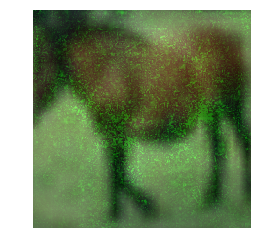

In [30]:
import interpretdl as it
from paddle.vision.models import resnet50

paddle_model = resnet50(pretrained=True)
sg = it.SmoothGradInterpreter(paddle_model, use_cuda=True)
gradients = sg.interpret("/home/aistudio/8.png", visual=True, save_path=None)

In [33]:
ResNet50_result = [n for n, v in paddle_model.named_sublayers()]
print(ResNet50_result)

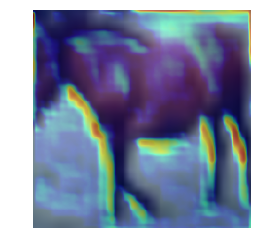

In [35]:
gradcam = it.GradCAMInterpreter(paddle_model, use_cuda=True)

heatmap = gradcam.interpret(
        "/home/aistudio/8.png",
        'conv1',
        visual=True,
        save_path=None)

# 五、总结与升华

- 本文最重要的地方在于神经网络工作的基本原理，只有搞懂了原理，才能更好地进行超参优化，得到的模型效果才会更好。
- 对于模型组网，最重要的是学会使用SubClass形式组网，使用套件虽然简单，但是可定制化程度较低，如果是科研需要，建议一定要学会用SubClass形式组网。
- 模型训练是本文中最简单的部分，只需要按照文档在操作即可，但是超参数的选择有很多讲究，超参的好坏往往会影响模型的最终结果
- 效果展示是一个项目的加分项，如果是科研需要，那么你也需要可视化地展示你的工作成果，这也是十分重要的。

# 作者简介

> 北京联合大学 机器人学院 自动化专业 2018级 本科生 郑博培

> 中国科学院自动化研究所复杂系统管理与控制国家重点实验室实习生

> 百度飞桨开发者技术专家 PPDE

> 百度飞桨官方帮帮团、答疑团成员

> 深圳柴火创客空间 认证会员

> 百度大脑 智能对话训练师

> 阿里云人工智能、DevOps助理工程师

我在AI Studio上获得至尊等级，点亮10个徽章，来互关呀！！！<br>
[https://aistudio.baidu.com/aistudio/personalcenter/thirdview/147378](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/147378)

![](https://ai-studio-static-online.cdn.bcebos.com/187d359bec3349c5a5e581bea14a4d2fb121952a86c342aea0eca063ed17b9a1)
